# Classification on a time series with TensorFlow

Using a modified Fizz-Buzz as in the original post of Joel Grus "[Fizz Buzz in TensorFlow](https://joelgrus.com/2016/05/23/fizz-buzz-in-tensorflow/)"

### Learning goals:
- Differences between the space split on a continuous functions and a time series
- Recurrent Neural Networks (RNN)
- Long-Short Term Memory (LSTM)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import scikitplot as skplt
import pandas

# Generator model

Use the Fizz-Buzz as a data model (https://en.wikipedia.org/wiki/Fizz_buzz)

We will reuse the model of Joel Grus with one-hot encoded data


In [3]:
def fizz_buzz(i, asInt = False):
    if asInt:
        if   i % 15 == 0: return 3
        elif i % 5  == 0: return 2
        elif i % 3  == 0: return 1
        else:             return 0
    else:
        if   i % 15 == 0: return "fizzbuzz"
        elif i % 5  == 0: return "buzz"
        elif i % 3  == 0: return "fizz"
        else:             return str(i)
    
def fizz_buzz_prediction(i, prediction):
    return [str(i), "fizz", "buzz", "fizzbuzz"][prediction]

# Joel Grus's implementation

Training with integers from 101 up to 2**10 = 1024 using one-hot encoded

Reference code: https://github.com/joelgrus/fizz-buzz-tensorflow/blob/master/fizz_buzz.py

In [74]:
NUM_OUT = 4
NUM_DIGITS = 10
NUM_HIDDEN = 100

def binary_encode(i, num_digits):
    return np.array([i >> d & 1 for d in range(num_digits)])

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

# Training data
trX = np.array([binary_encode(i, NUM_DIGITS) for i in range(101, 2 ** NUM_DIGITS)])
trY = np.array([fizz_buzz(i, True)           for i in range(101, 2 ** NUM_DIGITS)])

# Tensorflow model
X = tf.placeholder("float", [None, NUM_DIGITS], name='X')
Y = tf.placeholder("int32", [None], name='Y')

w_h = init_weights([NUM_DIGITS, NUM_HIDDEN])
w_o = init_weights([NUM_HIDDEN, NUM_OUT])

# Layer 1 with Relu activation
h = tf.nn.relu(tf.matmul(X, w_h))

# Layer 2
py_x = tf.matmul(h, w_o)

# Output prediction
predict_op = tf.argmax(py_x, 1)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=py_x, labels=Y))

train_op = tf.train.AdamOptimizer(0.05).minimize(cost)

In [75]:
BATCH_SIZE = 128
N_EPOCHS = 10000

init = tf.global_variables_initializer() 

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(N_EPOCHS+1):
        p = np.random.permutation(range(len(trX)))
        trX, trY = trX[p], trY[p]
        
        for start in range(0, len(trX), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
            
        if epoch % 1000 == 0:
            accuracy = np.mean(trY == sess.run(predict_op, feed_dict={X: trX, Y: trY}))
            print(epoch, accuracy)
            
    # And now for some fizz buzz
    numbers = np.arange(1, 101)
    teX = np.transpose(binary_encode(numbers, NUM_DIGITS))
    teYEst = sess.run(predict_op, feed_dict={X: teX})
    output = np.vectorize(fizz_buzz_prediction)(numbers, teYEst)

0 0.5341278439869989
1000 0.9967497291440953
2000 0.9859154929577465
3000 0.9934994582881906
4000 1.0
5000 1.0
6000 1.0
7000 1.0
8000 0.9609967497291441
9000 1.0
10000 1.0


Few modifications were performed to this implementation:
- Use Adam optimizer, faster to converge and more efficient
- Fix the code for TensorFlow v1.4 & v1.14
- Only print the metrics every 1000 epochs
- Use the 1-hot encoding only on the Cost (through tf.nn.sparse_softmax_cross_entropy_with_logits)

Let's continue the dialog of Joel with the interviewer...

__interviewer:__ It seems that model is overfitting

__Joel:__ Why do you say so?

__interviewer:__ There are more than 1000 parameters, the training dataset is lower than 1000 points.

Moreover, 2 (the one-hot encode base), 3 and 5 (the Fizzbuzz parameters) are prime numbers. in consequence, the one-encoded input is little more than a random sequence

In [76]:
fizzBuzzLabels = np.vectorize(fizz_buzz)(numbers, True)

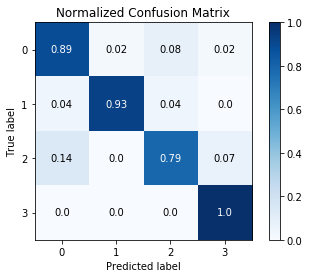

In [77]:
skplt.metrics.plot_confusion_matrix(fizzBuzzLabels, teYEst, normalize=True);

The estimation on test data is confirming the overfitting, generalization accuracy is lower than the training accuracy and varies a lot between categories

# Fizzbuzz as a time series

Above implementation relies on the sample index and is explicitly discarding the time series information through a permutation at every epoch of the estimation.

In [242]:
n = 32768
# Using a single fake feature as input
nFeatures = 1
xTrain =  np.ones(n) # np.random.normal(0, 1.0, n)
#xTrain[1:n:2] = -1 
# Output is the integer corresponding to the class [0, 4]
nClasses = 4
yTrain = np.vectorize(fizz_buzz)(range(n), True)

In [259]:
# Mini batch number of items
nBatchItems = 64
# Length of the RNN state
nStateSamples = 64
# End of back propagation
nBackpropagationSamples = 32
# Nunber of batches
nBatches = n//nBatchItems//nBackpropagationSamples

# Reshape the input into batches
xTrainBatched = xTrain.reshape(nBatchItems, -1)
yTrainBatched = yTrain.reshape(nBatchItems, -1)
print('Train x shape:', xTrainBatched.shape, ', y shape:', yTrainBatched.shape, ', number of batches:', nBatches)

Train x shape: (64, 512) , y shape: (64, 512) , number of batches: 16


## TensorFlow basic model

Let's create a TensorFlow model from scratch, i.e. without using predesigned RNN cells

The input must be shaped by the number of batches

References:
- [How to build a Recurrent Neural Network in TensorFlow (1/7) - Medium](https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767)

Naming conventions:
- Symbolic variables and placeholders start with uppercase

In [260]:
X = tf.placeholder(tf.float32, [nBatchItems, nBackpropagationSamples], name='X')
Y = tf.placeholder(tf.int32,   [nBatchItems, nBackpropagationSamples], name='Y')

InitState = tf.placeholder(tf.float32, [nBatchItems, nStateSamples], name='InitState')

# Layer 1
W1 = tf.Variable(np.random.rand(nStateSamples + 1, nStateSamples), dtype=tf.float32, name='W1')
B1 = tf.Variable(np.zeros((1, nStateSamples)),                     dtype=tf.float32, name='B1')

# Layer 2
W2 = tf.Variable(np.random.rand(nStateSamples, nClasses),          dtype=tf.float32, name='W2')
B2 = tf.Variable(np.zeros((1, nClasses)),                          dtype=tf.float32, name='B2')

# Unpack columns
InputsSeries = tf.unstack(X, axis=1)
LabelsSeries = tf.unstack(Y, axis=1)

In [261]:
# Forward pass
CurrentState = InitState
StateSeries = []
LocalLosses = []
PredictionSeries = []

# Unroll states on the length of the backpropagation
for Inp, Labels in zip(InputsSeries, LabelsSeries):
    
    # First layer
    X1 = tf.reshape(Inp, [nBatchItems, 1])
    ## Concatenate X1 and current state
    Y1 = tf.matmul(tf.concat([X1, CurrentState], 1), W1) + B1  
    ## Activation with tanh (squashing) to update current state
    CurrentState = nClasses * tf.tanh(Y1) 
    
    # Second layer
    ## Logits
    Y2 = tf.matmul(CurrentState, W2) + B2
    ## Predictions
    Predictions = tf.nn.softmax(Y2)
    
    # Local loss
    LocalLoss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Y2, labels=Labels)
    
    # Archived values
    StateSeries.append(CurrentState)
    LocalLosses.append(LocalLoss)
    PredictionSeries.append(Predictions)
    
# Mean loss on state steps
TotalLoss = tf.reduce_mean(LocalLosses)

# Finally the optimizer on the total loss
TrainStep = tf.train.RMSPropOptimizer(0.01).minimize(TotalLoss)

### TensorFlow fit

In [262]:
nEpochs = 16

init = tf.global_variables_initializer() 

with tf.Session() as sess:
    sess.run(init)
    
    losses = []
   
    for epoch in range(nEpochs):
        x, y = xTrainBatched, yTrainBatched
        _currentState = np.zeros((nBatchItems, nStateSamples))

        for batch_idx in range(nBatches):
            start_idx = batch_idx * nBackpropagationSamples
            end_idx = start_idx + nBackpropagationSamples

            batchX = x[:, start_idx:end_idx]
            batchY = y[:, start_idx:end_idx]

            _trainStep, _totalLoss, _currentState = sess.run(
                [TrainStep, TotalLoss, CurrentState],
                feed_dict={X: batchX, Y: batchY, InitState: _currentState})
            
            # Saved values
            losses.append(_totalLoss)
            
            
    # Final predictions on train data  
    predictions = np.zeros(n)
    _currentState = np.zeros((nBatchItems, nStateSamples))
    x = xTrainBatched
    for batch_idx in range(nBatches):
        start_idx = batch_idx * nBackpropagationSamples
        end_idx = start_idx + nBackpropagationSamples

        batchX = x[:, start_idx:end_idx]

        ps = sess.run(PredictionSeries, feed_dict={X: batchX, InitState: _currentState})
        predStart_idx = batch_idx * nBatchItems * nBackpropagationSamples
        predEnd_idx = predStart_idx + nBatchItems
        for pred in ps:
            predictions[predStart_idx:predEnd_idx] = np.argmax(pred, axis=1)
            predStart_idx = predEnd_idx
            predEnd_idx = predStart_idx + nBatchItems
            
            
      #  print("End of epoch: {:d}, loss: {:.3e}".format(epoch, _totalLoss))
    
    # Final estimator coefficients
    w1, b1, w2, b2 = sess.run([W1, B1, W2, B2])

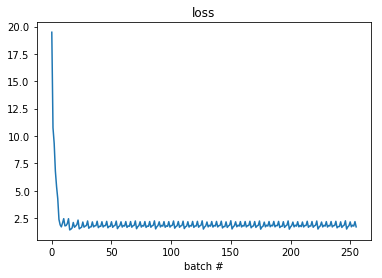

In [263]:
plt.plot(losses)
plt.xlabel('batch #')
plt.title('loss');

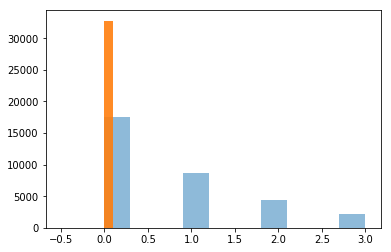

In [264]:
plt.hist(yTrain, 10, alpha=0.5);
plt.hist(predictions, 10, alpha=0.9);

In [265]:
predictions[600:700]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])